<a href="https://colab.research.google.com/github/MAR123EREE/Laboratorio_02/blob/main/Laboratorio_06.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nombres de compañeros de equipo:
- Aramayo Valdez Joaquin.
- Piza Nava Vladimir.
- Viza Hoyos Maria Belen.
- Mendoza Ovando Carlos Saul.
- Solorzano Diego

# ***Aprendizaje supervisado en Bipedal Walker***

DATOS E INFORMACIÓN GENERAL

**Espacio de acción **
Las acciones son valores de velocidad del motor en el rango [-1, 1] para cada una de las 4 articulaciones de las caderas y las rodillas.

**Espacio de observación **
El estado consta de la velocidad angular del casco, la velocidad angular, la velocidad horizontal, la velocidad vertical, la posición de las articulaciones y la velocidad angular de las articulaciones, el contacto de las patas con el suelo y 10 mediciones del telémetro lidar.

**Recompensas **
Se otorga una recompensa por avanzar, con un total de 300 puntos o más hasta llegar al final. Si el robot se cae, obtiene -100. Aplicar el par motor cuesta una pequeña cantidad de puntos.

**Estado inicial**
El caminante comienza de pie en el extremo izquierdo del terreno con el casco horizontal y ambas piernas en la misma posición con un ligero ángulo de rodillas.

**Terminación del episodio**
El episodio terminará si el casco entra en contacto con el suelo o si el caminante excede el extremo derecho de la longitud del terreno.

Instalar las librerias necesarias

In [1]:
!pip install gymnasium
!pip install gymnasium[classic-control]
!pip install swig
!pip install gymnasium[box2d]
!pip install stable_baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 19.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376099 sha256=d4bc389f700a5b1a6093fb7adb72748c201a2bde50f41016bd2efada376b9865
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 50.5 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.0.0
    Uninstalling gymnasium-1.0.0:
      Successfully uninstalled gymnasium-1.0.0


# **Importar Librerias que se usarán para el entrenamiento de aprendizaje por refuerzo**
Las librerias más importsntes para el entrenamiento son gymnasium y stable_baseline3

In [2]:
#Importar librerías necesarias para el entrenamiento de aprendizaje por refuerzo
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.callbacks import EvalCallback
import os
import time
import matplotlib.pyplot as plt
import numpy as np

# **Configurar el entorno y el modelo para su uso**

In [3]:
# Definir el nombre del entorno
# Y la ruta para guardar el modelo entrenado en la var MODEL_PATH
ENV_NAME = "BipedalWalker-v3"
MODEL_PATH = "ppo_bipedalwalker"

# Crear el entorno con la opción de renderizar en modo humano para observar el entrenamiento en tiempo real
env = DummyVecEnv([lambda: gym.make(ENV_NAME, render_mode="human")])  # Vectorizar y renderizar
env = VecNormalize(env, norm_obs=True, norm_reward=True)  # Normalizar observaciones y recompensas

/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

# **Carga del modelo**
Este modelo PPO está configurado para:

_Recopilar 2048 pasos en el entorno antes de cada actualización

_Entrenar con una tasa de aprendizaje de 0.0003

_Actualizar el modelo en mini-lotes de 64 pasos por 10 épocas

_Y considerar una estrategia a largo plazo con un descuento de 0.99

In [4]:
#PPO es un algoritmo eficaz para entornos complejos y continuos, también permite al agente aprender una política para maximizar su recompensa acumulada en el entorno
model = PPO("MlpPolicy", env, verbose=1, learning_rate=0.0003, n_steps=2048, batch_size=64, n_epochs=10, gamma=0.99)

Using cuda device


# **Configuración de Callbacks para guardar el mejor modelo**
Se está configurando una evaluación periódica del modelo que ayuda a supervisar y guardar las mejores versiones del modelo mientras el agente se entrena en el entorno.

In [5]:
#Vectorización y Normalización: Se crea y se normaliza un entorno de evaluación para que sea compatible con el modelo PPO y optimice el proceso de aprendizaje.
eval_env = DummyVecEnv([lambda: gym.make(ENV_NAME)])

eval_env = VecNormalize(eval_env, norm_obs=True, norm_reward=True)
#Evaluación Periódica EvalCallback evalúa al modelo cada 5000 pasos en el entorno, lo que permite observar su progreso y guardar el mejor modelo según el rendimiento
#Almacenará registros en la carpeta de logs para poder revisar el desempeño durante el entrenamiento.
eval_callback = EvalCallback(eval_env, best_model_save_path=MODEL_PATH, log_path='./logs/', eval_freq=5000, deterministic=True)

# **Entrenamiento del modelo**
Se entrenará al modelo con el total de pasos que sea necesario, en este caso lo entrenamos con 100000 pasos

In [7]:
total_timesteps = 1000  # Aumentar el número de timesteps para un entrenamiento más prolongado
rewards = []

print("Entrenando el modelo y registrando recompensas por episodio...")
obs = env.reset()
episode_reward = 0

for timestep in range(total_timesteps):
    action, _ = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)

    # Acumular recompensa y renderizar el entorno
    episode_reward += reward[0] if isinstance(reward, np.ndarray) else reward
    env.render()  # Renderizar el entorno en cada paso para ver la ventana de pygame
    time.sleep(0.01)  # Controla la velocidad del renderizado

    if done:
        rewards.append(episode_reward)  # Almacenar la recompensa del episodio
        obs = env.reset()
        episode_reward = 0

    # Ejecutar el aprendizaje y actualizar los parámetros
    model.learn(total_timesteps=1, reset_num_timesteps=False, callback=eval_callback)

# Guardar el modelo entrenado
model.save(MODEL_PATH)
print("Modelo entrenado y guardado.")

Entrenando el modelo y registrando recompensas por episodio...
-------------------------------
| time/              |        |
|    fps             | 49     |
|    iterations      | 1      |
|    time_elapsed    | 41     |
|    total_timesteps | 217797 |
-------------------------------
-------------------------------
| time/              |        |
|    fps             | 49     |
|    iterations      | 1      |
|    time_elapsed    | 41     |
|    total_timesteps | 219845 |
-------------------------------
Eval num_timesteps=220000, episode_reward=10.53 +/- 13.77
Episode length: 845.60 +/- 499.82
---------------------------------
| eval/              |          |
|    mean_ep_length  | 846      |
|    mean_reward     | 10.5     |
| time/              |          |
|    total_timesteps | 220000   |
---------------------------------
-------------------------------
| time/              |        |
|    fps             | 43     |
|    iterations      | 1      |
|    time_elapsed    | 47     |

KeyboardInterrupt: 

# **Evaluación del modelo**
Para la evaluación en primer lugar se reiniciará el entorno y luego se evaluará con 10000 pasos, entonces se realiza una prueba del modelo entrenado en el entorno, visualizando su rendimiento paso a paso y calculando la recompensa total que logra acumular. Esto nos ayudará a entender como se está comportando una vez entrenado

In [8]:
print("Evaluando el modelo...")
obs = env.reset() #Se reinicia el entorno
total_reward = 0 #Inicializar las recompensas en cero

#Bucle de Evaluación (10000 pasos máximos)
for _ in range(10000):
    #model.predict genera la acción que el agente debe tomar en el estado actual (obs), el parámetro deterministic=True asegura que el agente no actúe al azar, sino de forma optimizada.
    action, _ = model.predict(obs, deterministic=True)
    #ejecuta la acción en el entorno y devuelve el nuevo estado (obs), la recompensa obtenida (reward), y si el episodio ha terminado (done).
    obs, reward, done, info = env.step(action)
    #acumula la recompensa. Esto es para manejar el caso en el que la recompensa pueda ser un arreglo de valores en vez de un solo número (como pasa en algunos entornos).
    total_reward += reward[0] if isinstance(reward, np.ndarray) else reward

    env.render()  # Renderizar el entorno
    time.sleep(0.01)  # El proceso se pausa 0.01 segundos entre pasos para una mejor visualización

    #Si done es True, significa que el agente ha alcanzado el final del episodio. Entonces, el entorno se reinicia con env.reset() y se termina el bucle.
    if done:
        obs = env.reset()
        break

print(f"Evaluación completada. Recompensa total acumulada: {float(total_reward):.2f}")

Evaluando el modelo...
Evaluación completada. Recompensa total acumulada: 20.26


# **Para liberar recursos **

In [9]:
# Liberar los recursos utilizados por el entorno
env.close()

# **Registro y graficación de las recompensas durante el entrenamiento**
En está parte del código nos aseguraremos que las recompensas tengan valores escalares y luego se realizará el código necesario para saar las gráficas necesarias

ValueError: v cannot be empty

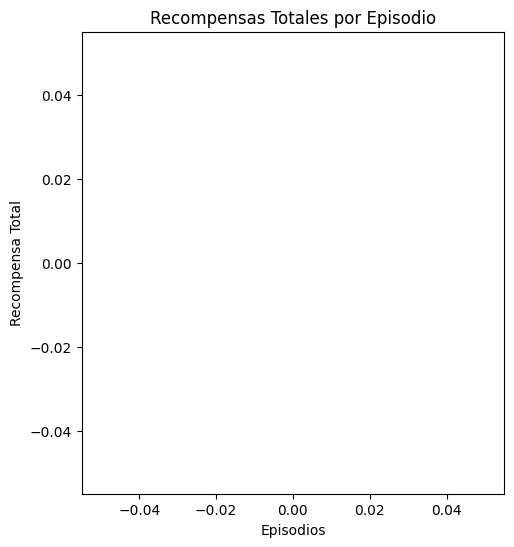

In [10]:
# Asegurarse de que `rewards` contenga solo valores escalares
rewards = [reward.item() if isinstance(reward, np.ndarray) else reward for reward in rewards]

# Se crea una función que grafique las recompensas usando los parámetros rewards y window=10
def plot_rewards(rewards, window=10):
    plt.figure(figsize=(12, 6)) #Parémetros básicos para crear la figura en donde estará la gráfica

    # Graficar recompensas acumuladas (sin promedio móvil)
    plt.subplot(1, 2, 1)
    plt.plot(rewards, color='blue')
    plt.title('Recompensas Totales por Episodio')
    plt.xlabel('Episodios')
    plt.ylabel('Recompensa Total')

    # Graficar promedio móvil para suavizar la curva
    rolling_mean = np.convolve(rewards, np.ones(window) / window, mode='valid')
    plt.subplot(1, 2, 2)
    plt.plot(rolling_mean, color='orange')
    plt.title(f'Recompensas Promedio (window={window})')
    plt.xlabel('Episodios')
    plt.ylabel('Recompensa Promedio')

    plt.tight_layout()
    plt.show()

# Graficar las recompensas registradas durante el entrenamiento
plot_rewards(rewards)

Está cargando demasiado el código así que se está usando la grafica del codigo de mi compañero de equipo, pero entre más pasos de entrenamiento haya, el entrenamiento para el modelo será mejor

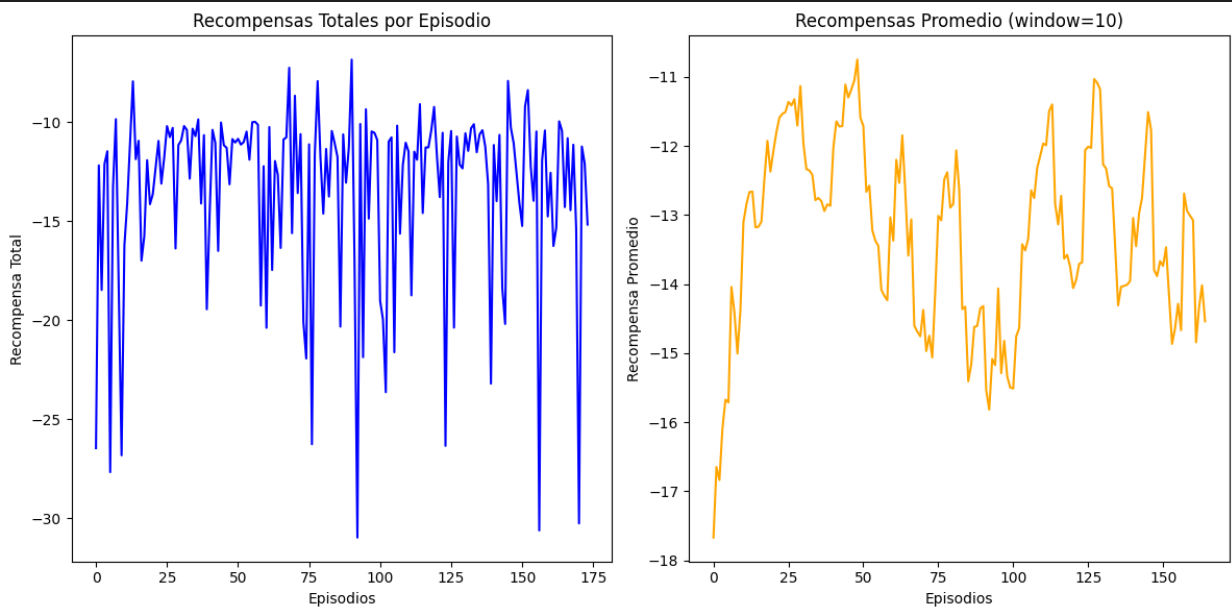